In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm, trange

In [2]:
with open('hw4_data/nyt_data.txt') as f:
    raw_file = f.readlines()

word_to_id = {}
id_to_word = {}

usa = open('hw4_data/nyt_vocab.dat')
counter = 0
for line in usa:
    word = line.strip()
    word_to_id[word] = counter
    id_to_word[counter] = word
    counter+=1
    
word_list = []
count_list = []

for _,doc in enumerate(raw_file):
    words = doc.strip().split(',')
    w_l = []
    c_l = []
    
    for vocab in words:
        ind, num = vocab.split(':')
        w_l.append(int(ind)-1)
        c_l.append(int(num))
    
    word_list.append(w_l)
    count_list.append(c_l)

In [3]:
padded_words = tf.keras.preprocessing.sequence.pad_sequences(word_list, padding = 'post', value = 0)
padded_counts = tf.keras.preprocessing.sequence.pad_sequences(count_list, padding = 'post', value = 0)

In [17]:
def make_encoder(num_layers, dim, T, V, L, activation = 'relu', residual = False):
    # we build a keras sequential model with prescribed model
    # first embed into the dimensions
    inputs_w = tf.keras.Input(shape = (L, ))
    inputs_c = tf.keras.Input(shape = (L, ))
    embedded = tf.keras.layers.Embedding(V, dim)(inputs_w)
    x = tf.reduce_sum(embedded * tf.expand_dims(inputs_c, axis = -1), axis = 1) # bow
    
    for l in range(num_layers):
        if residual:
            x = tf.keras.layers.Dense(dim, activation=activation)(x) + x
        else:
            x = tf.keras.layers.Dense(dim, activation=activation)(x)
    
    x = tf.keras.layers.Dense(T, activation = None)(x)
    
    encoder = tf.keras.Model(inputs = [inputs_w, inputs_c], outputs=x)
    return encoder

class sampler_indices:

    def __init__(self, N, batch_size):
        self.batch_size = batch_size
        self.i = 0
        self.N = N
        self.ind = tf.range(self.N)
        self.ind = tf.random.shuffle(self.ind)
        
    def take(self, ):
        i0 = self.i%self.N
        i1 = (self.i + self.batch_size)%self.N
        
        if i0 < i1:

            self.i = i1
            return self.ind[i0:i1]
        
        else:
            x0 = self.ind[i0:]
            x1 = self.ind[:i1]
                
            self.i = i1
            self.ind = tf.random.shuffle(self.ind)
            return np.concatenate((x0, x1), axis = 0)
        
@tf.custom_gradient
def naive_natural_gradient_on_backprop(a, ):
    def grad(da):
        Ia = dirichlet_fisher_inv(a)
        da_tilde = tf.einsum("tmn,tn->tm", Ia, da)
        return da_tilde
    return tf.identity(a), grad

@tf.custom_gradient
def natural_gradient_on_backprop(a, ):
    def grad(da):
#         Ia = dirichlet_fisher_inv(a)
#         da_tilde = tf.einsum("tmn,tn->tm", Ia, da)
        da_tilde = multiply_by_fisher_inv(a, da)
        return da_tilde
    return tf.identity(a), grad

def _calculate_rankone(alphas):
    alpha0 = tf.reduce_sum(alphas, axis = -1)
    dg_a0 = tf.math.polygamma(1., alpha0)
    res = tf.transpose(dg_a0 * tf.ones((alphas.shape[1], alphas.shape[1], alphas.shape[0], )), (2, 0, 1)) # a more readable way of writing this is probably einsum
    return res

def dirichlet_fisher(alphas):
    dg_a = tf.math.polygamma(1., alphas)
    D = tf.linalg.diag(dg_a)
    R1 = _calculate_rankone(alphas)
    
    return D-R1

@tf.function
def dirichlet_fisher_inv(alphas):
    alpha0 = tf.reduce_sum(alphas, axis=-1)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    A_inv = tf.linalg.diag(inv_dg_a) # part 1
    
    A_inv_mul_one = inv_dg_a # part 2
    corr_top = tf.einsum('ki,kj->kij', A_inv_mul_one, A_inv_mul_one)
    corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1)

    return (A_inv - corr_top/tf.reshape(corr_bot, (-1, 1, 1)))

@tf.function
def multiply_by_fisher_inv(alphas, x):
    # alphas is of shape (N, D)
    # x of shape (N, D)
    alpha0 = tf.reduce_sum(alphas, axis=-1, keepdims = True)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    # first get the multiply by inv diag matrix
    A_inv_mul_x = inv_dg_a * x
    Corr_top_mul_x = inv_dg_a * tf.reduce_sum(A_inv_mul_x, axis=-1, keepdims=True) # (N, D) * (N, 1)
    Corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1, keepdims = True)
    Corr_mul_x = Corr_top_mul_x/Corr_bot
    
    return A_inv_mul_x - Corr_mul_x

def calculate_doc_probs3(d_probs, t_probs):
    res = d_probs@t_probs
    return res

def get_top_words_per_topic2(topics, top_k = 20):
    # doesn't matter they are logits or not.. exp is a monotonic function
    top_words = tf.argsort(-topics, axis = -1)[:, :top_k]
    res = []
    for t in range(topics.shape[0]):
        res.append([id_to_word[i.numpy()] for i in top_words[t, :]])
    
    return res

In [43]:
def train_amortized_lda(
    t_params, 
    d_encoder,
    optimizer, 
    theta_prior = 1.,
    beta_prior = 1.,
    D = padded_words.shape[0],
    scale = 1.,
    epochs = 100, 
    natural = False, 
    batch_size = 64, 
    verbose = False,
):
    d_prior = tfd.Dirichlet(tf.ones((t_params.shape[0], )) * theta_prior)
    t_prior = tfd.Dirichlet(tf.ones((t_params.shape[1], )) * beta_prior)
    
    epochs = epochs*(D//batch_size)
    if verbose:
        tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
    else:
        tqdm_range = range(epochs)
    loss_records = []

    for e in tqdm_range:
        i = ind_sampler.take()
        with tf.GradientTape() as tape:
            w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
            d_logits_i = d_encoder([w, c])
            if natural:
                d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
            else:
                d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
            d_sample = d_post.sample()
            
            if natural:
                t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_params)))
            else:
                t_post = tfd.Dirichlet(tf.math.softplus(t_params))
            t_sample = t_post.sample()

            prob_mat = calculate_doc_probs3(d_sample, t_sample)
            lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
            sum_lp = tf.reduce_sum(c * lp, axis = 1)
            kl = tfd.kl_divergence(d_post, d_prior)

            loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # first take mean, then replicate it D times
            loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) 
            loss /= scale

        grads = tape.gradient(loss, [t_params, ]+d_encoder.trainable_variables )
        opt.apply_gradients(zip(grads, [t_params,]+d_encoder.trainable_variables))
        loss_records.append(loss.numpy() * scale)
        if verbose:
            tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    
    return loss_records



In [75]:
def train_amortized_lda2(
    t_params, 
    d_encoder,
    opt_top = None,
    opt_doc = None,
    theta_prior = 1.,
    beta_prior = 1.,
    D = padded_words.shape[0],
    scale = 1.,
    epochs = 100, 
    natural_doc = False, 
    natural_top = False,
    batch_size = 64, 
    verbose = False,
):
    d_prior = tfd.Dirichlet(tf.ones((t_params.shape[0], )) * theta_prior)
    t_prior = tfd.Dirichlet(tf.ones((t_params.shape[1], )) * beta_prior)
    
    epochs = epochs*(D//batch_size)
    if verbose:
        tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
    else:
        tqdm_range = range(epochs)
    loss_records = []

    for e in tqdm_range:
        i = ind_sampler.take()
        with tf.GradientTape() as tape:
            w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
            d_logits_i = d_encoder([w, c])
            if natural_doc:
                d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
            else:
                d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
            d_sample = d_post.sample()
            
            if natural_top:
                t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_params)))
            else:
                t_post = tfd.Dirichlet(tf.math.softplus(t_params))
            t_sample = t_post.sample()

            prob_mat = calculate_doc_probs3(d_sample, t_sample)
            lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
            sum_lp = tf.reduce_sum(c * lp, axis = 1)
            kl = tfd.kl_divergence(d_post, d_prior)

            loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # first take mean, then replicate it D times
            loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) 
            loss /= scale

        grads = tape.gradient(loss, [t_params, ]+d_encoder.trainable_variables )
        opt_top.apply_gradients(zip(grads[0], [t_params,]))
        opt_doc.apply_gradients(zip(grads[1], d_encoder.trainable_variables))
        loss_records.append(loss.numpy() * scale)
        if verbose:
            tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    
    return loss_records

In [ ]:
def train_amortized_lda2(
    t_params, 
    d_encoder,
    opt_top = None,
    opt_doc = None,
    theta_prior = 1.,
    beta_prior = 1.,
    D = padded_words.shape[0],
    scale = 1.,
    epochs = 100, 
    natural_doc = False, 
    natural_top = False,
    batch_size = 64, 
    verbose = False,
):
    d_prior = tfd.Dirichlet(tf.ones((t_params.shape[0], )) * theta_prior)
    t_prior = tfd.Dirichlet(tf.ones((t_params.shape[1], )) * beta_prior)
    
    epochs = epochs*(D//batch_size)
    if verbose:
        tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
    else:
        tqdm_range = range(epochs)
    loss_records = []

    for e in tqdm_range:
        i = ind_sampler.take()
        with tf.GradientTape() as tape:
            w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
            d_logits_i = d_encoder([w, c]) # this we will record
            if natural_doc:
                d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
            else:
                d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
            d_sample = d_post.sample()
            
            if natural_top:
                t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_params)))
            else:
                t_post = tfd.Dirichlet(tf.math.softplus(t_params))
            t_sample = t_post.sample()

            prob_mat = calculate_doc_probs3(d_sample, t_sample)
            lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
            sum_lp = tf.reduce_sum(c * lp, axis = 1)
            kl = tfd.kl_divergence(d_post, d_prior)

            loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # first take mean, then replicate it D times
            loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) 
            loss /= scale

        grads = tape.gradient(loss, [t_params, ]+d_encoder.trainable_variables )
        opt_top.apply_gradients(zip(grads[0], [t_params,]))
        opt_doc.apply_gradients(zip(grads[1], d_encoder.trainable_variables))
        loss_records.append(loss.numpy() * scale)
        if verbose:
            tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    
    return loss_records

In [149]:
?tf.optimizers.SGD

In [153]:
T = 30
D = len(word_list)
V = len(word_to_id)

num_runs = 1
step_sizes = [1e-3, 1e-4, ]
batch_sizes = [64, ]
optimization_methods = ['ngd', ]
epochs = [100,]
counter = 0
max_counter = len(batch_sizes) * len(optimization_methods) * len(epochs) * len(step_sizes)

res = {}

for ss in step_sizes:
    for bs in batch_sizes:
        for om in optimization_methods:
            for e in epochs:
                key = "{}/batch_{}epochs_{}_{}".format(bs, e, ss, om)
                res[key] = []

                for _ in tqdm(range(num_runs)):
                    ind_sampler = sampler_indices(padded_words.shape[0], batch_size = bs)
                    d_encoder = make_encoder(3, 128, T, len(word_to_id), padded_words.shape[1])
                    t_p = tf.Variable(tf.initializers.GlorotNormal()((T, V)))
                    if om == 'ngd':
                        opt = tf.optimizers.SGD(ss, clipvalue = ss*10.)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = True, batch_size = bs, verbose = True, scale = 1000000.)
                    elif om == 'adam':
                        opt = tf.optimizers.Adam(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = False, batch_size = bs, verbose = True, scale = 1000.)
                    elif om == 'sgd':
                        opt = tf.optimizers.SGD(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = False, batch_size = bs, verbose = True, scale = 1000.)
                    elif om == 'rms_prop':
                        opt = tf.optimizers.RMSprop(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = False, batch_size = bs, verbose = True, scale = 1000.)

                    top_word_rec = get_top_words_per_topic2(t_p.numpy(), top_k=10)
                    kl_div_res = tfd.kl_divergence(tfd.Dirichlet(tf.math.softplus(t_p)), tfd.Dirichlet(tf.ones((t_p.shape[1], )) * 1.)) 
                    res[key].append({'loss': loss_rec,
                                     'top_words': top_word_rec,
                                     'kl_divs': kl_div_res.numpy()})       
                counter += 1
                print("{} out of {} done".format(counter, max_counter))

-ELBo:   0%|          | 0/13100 [00:00<?, ?it/s]

1 out of 2 done


-ELBo: 9.64: 100%|██████████| 13100/13100 [23:27<00:00,  9.78it/s]

2 out of 2 done


In [152]:
top_word_rec = get_top_words_per_topic2(t_p.numpy(), top_k=10)
kl_div_res = tfd.kl_divergence(tfd.Dirichlet(tf.math.softplus(t_p)), tfd.Dirichlet(tf.ones((t_p.shape[1], )) * 1.)) 
res[key].append({'loss': loss_rec,
                 'top_words': top_word_rec,
                 'kl_divs': kl_div_res.numpy()})  

In [23]:
def calculate_unique_words(list_of_list):
    res_set = set({})
    for l in list_of_list:
        res_set = res_set.union(set(l))

    return res_set

def calculate_per_epoch_loss(loss_list, num_per_epoch):
    return np.add.reduceat(loss_list, np.arange(0, len(loss_list), num_per_epoch))/num_per_epoch

def plot_results(results):
    plt.figure(figsize=(12, 10))
    for key in results:
        if results[key] != []:
            print("================= {} =================".format(key))
            if key[:2] == '64':
                num_per_epoch = padded_words.shape[0]//64
            elif key[:3] == '128':
                num_per_epoch = padded_words.shape[0]//128

            res_key = results[key]

            kl_divs_key = [_r['kl_divs'] for _r in res_key]
            uniq_key = [calculate_unique_words(_r['top_words']) for _r in res_key]
            loss_key = [_r['loss'] for _r in res_key]

            kl_mean = [np.mean(kl) for kl in kl_divs_key]
            kl_std = [np.std(kl) for kl in kl_divs_key]
            u_mean = np.mean([len(u) for u in uniq_key])
            u_std = np.std([len(u) for u in uniq_key])
            epoch_loss_key = [calculate_per_epoch_loss(l, num_per_epoch) for l in loss_key]
            l_mean = np.array(epoch_loss_key).mean(axis = 0)
            l_std = np.array(epoch_loss_key).std(axis = 0)
            last_epoch_loss_key = [l[-1] for l in epoch_loss_key]

            print("kl means: {}, \n kl stdevs: {}".format(kl_mean, kl_std))
            print("mean kl means: {:.2f} +/- {:.2f}".format(np.mean(kl_mean), np.std(kl_mean)))
            print("number of unique words {:.2f} +/- {:.2f}".format(u_mean, u_std))
            print("last epoch loss (by 1000000): {:.2f} +/- {:.2f}".format(np.mean(last_epoch_loss_key)/1000000, np.std(last_epoch_loss_key)/1000000))
            l_s = key.split('_')
            label = ', '.join([l_s[0], l_s[2]]) if len(l_s) == 3 else ', '.join([l_s[0], '_'.join([l_s[2], l_s[3]])])
            plt.errorbar(np.arange(100), l_mean, yerr=l_std, label = label)
    
    plt.legend()
    plt.title("losses for different optimization methods, $\pm 1$ standard error error bar")
    plt.grid()
    plt.show()

In [54]:
T = 30
D = len(word_list)
V = len(word_to_id)

num_runs = 1
step_sizes = [1e-3, 1e-4, 1e-5]
batch_sizes = [64, ]
optimization_methods = ['ngd',]
epochs = [100,]
counter = 0
max_counter = len(batch_sizes) * len(optimization_methods) * len(epochs) * len(step_sizes)

res = {}

for ss in step_sizes:
    for bs in batch_sizes:
        for om in optimization_methods:
            for e in epochs:
                key = "{}/batch_{}epochs_{}_{}".format(bs, e, ss, om)
                res[key] = []

                for _ in tqdm(range(num_runs)):
                    ind_sampler = sampler_indices(padded_words.shape[0], batch_size = bs)
                    d_encoder = make_encoder(3, 128, T, len(word_to_id), padded_words.shape[1])
                    t_p = tf.Variable(tf.initializers.GlorotNormal()((T, V)))
                    if om == 'ngd':
                        opt = tf.optimizers.SGD(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = True, batch_size = bs, verbose = True, scale = 1000000.)
                    elif om == 'adam':
                        opt = tf.optimizers.Adam(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = False, batch_size = bs, verbose = True, scale = 1000.)
                    elif om == 'sgd':
                        opt = tf.optimizers.SGD(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = False, batch_size = bs, verbose = True, scale = 1000.)
                    elif om == 'rms_prop':
                        opt = tf.optimizers.RMSprop(ss)
                        loss_rec = train_amortized_lda(t_p, d_encoder, opt, epochs = e, natural = False, batch_size = bs, verbose = True, scale = 1000.)

                    top_word_rec = get_top_words_per_topic2(t_p.numpy(), top_k=10)
                    kl_div_res = tfd.kl_divergence(tfd.Dirichlet(tf.math.softplus(t_p)), tfd.Dirichlet(tf.ones((t_p.shape[1], )) * 1.)) 
                    res[key].append({'loss': loss_rec,
                                     'top_words': top_word_rec,
                                     'kl_divs': kl_div_res.numpy()})       
                counter += 1
                print("{} out of {} done".format(counter, max_counter))

-ELBo: 8.89:   0%|          | 1/13100 [00:00<32:07,  6.80it/s]

1 out of 3 done


-ELBo: 9.91:   0%|          | 1/13100 [00:00<31:02,  7.03it/s]

2 out of 3 done


-ELBo: 10.25: 100%|██████████| 13100/13100 [23:46<00:00,  9.31it/s]

3 out of 3 done


================= 64/batch_100epochs_0.001_ngd =================
kl means: [156.02898], 
 kl stdevs: [0.22514376]
mean kl means: 156.03 +/- 0.00
number of unique words 287.00 +/- 0.00
last epoch loss (by 1000000): 9.85 +/- 0.00
================= 64/batch_100epochs_0.0001_ngd =================
kl means: [155.94362], 
 kl stdevs: [0.3601313]
mean kl means: 155.94 +/- 0.00
number of unique words 288.00 +/- 0.00
last epoch loss (by 1000000): 9.90 +/- 0.00
================= 64/batch_100epochs_1e-05_ngd =================
kl means: [155.9418], 
 kl stdevs: [0.2995852]
mean kl means: 155.94 +/- 0.00
number of unique words 282.00 +/- 0.00
last epoch loss (by 1000000): 9.88 +/- 0.00


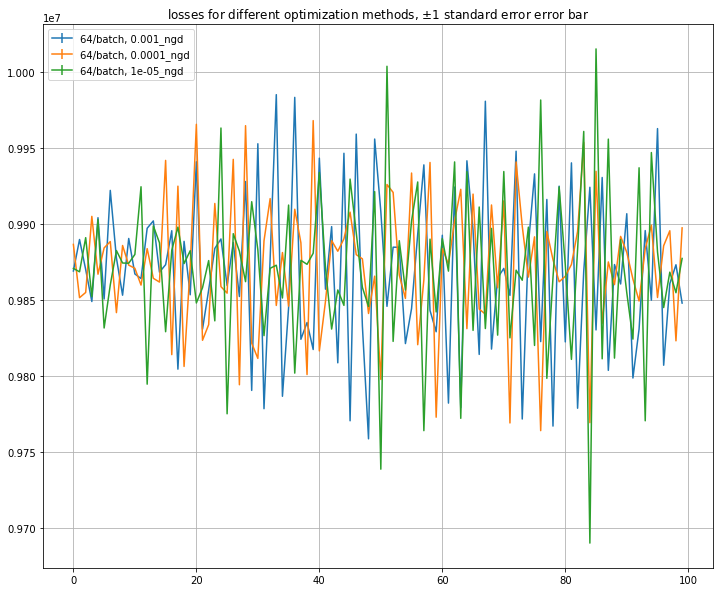

In [55]:
plot_results(res)

In [63]:
res['64/batch_100epochs_1e-05_ngd'][0]['top_words']

[['survey',
  'rookie',
  'definition',
  'quickly',
  'potentially',
  'buy',
  'costly',
  'actually',
  'obviously',
  'return'],
 ['fair',
  'union',
  'national',
  'short',
  'actress',
  'print',
  'exceed',
  'concrete',
  'monitor',
  'dealer'],
 ['campaign',
  'dangerous',
  'collective',
  'lover',
  'psychological',
  'regret',
  'affair',
  'perform',
  'discuss',
  'anti'],
 ['visit',
  'absolutely',
  'brothers',
  'selection',
  'factor',
  'slip',
  'sun',
  'cultural',
  'writer',
  'solution'],
 ['lecture',
  'appoint',
  'nice',
  'careful',
  'perfect',
  'stun',
  'deck',
  'basketball',
  'combination',
  'squeeze'],
 ['gallery',
  'aug',
  'accompany',
  'gov',
  'tech',
  'narrative',
  'line',
  'fighting',
  'uncertain',
  'select'],
 ['nearby',
  'compound',
  'rural',
  'recession',
  'jews',
  'spanish',
  'entitle',
  'conflict',
  'organizer',
  'recent'],
 ['faculty',
  'helicopter',
  'turn',
  'comprehensive',
  'plane',
  'small',
  'update',
  'slip

In [62]:
res.keys()

dict_keys(['64/batch_100epochs_0.001_ngd', '64/batch_100epochs_0.0001_ngd', '64/batch_100epochs_1e-05_ngd'])

Intercepting the gradient

In [146]:
@tf.custom_gradient
def forward_identity_backward_ones(a):
    def grad(da):
        da *= tf.constant([[0,0,0,1],
                           [0,0,0,0],
                           [1,0,0,0]], 'float32')
        return da
    return tf.identity(a), grad

In [147]:
base_variable = tf.Variable(tf.initializers.Zeros()((3,4)))

with tf.GradientTape() as tape:
    intermediate_tensor = tf.math.softplus(base_variable)
    end_tensor = tf.reduce_mean(forward_identity_backward_ones(intermediate_tensor))
    
grads = tape.gradient(end_tensor, [base_variable, intermediate_tensor])

In [148]:
grads

[<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
 array([[0.        , 0.        , 0.        , 0.04166667],
        [0.        , 0.        , 0.        , 0.        ],
        [0.04166667, 0.        , 0.        , 0.        ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
 array([[0.        , 0.        , 0.        , 0.08333334],
        [0.        , 0.        , 0.        , 0.        ],
        [0.08333334, 0.        , 0.        , 0.        ]], dtype=float32)>]

so this means we can 
1. take gradient w.r.t any intermediate tensors
2. measure